In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import bentoml
import PIL.Image
import keras_tuner as kt
import ast

In [14]:
fmnist = tf.keras.datasets.fashion_mnist

In [15]:
fmnist_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker",
"Bag", "Ankle boot"]

In [16]:
(training_images, training_labels), (test_images, test_labels) = fmnist.load_data()

In [17]:
training_images_hp = np.concatenate([training_images, test_images])
training_labels_hp = np.concatenate([training_labels, test_labels])
training_images_hp = np.expand_dims(training_images_hp,3)
training_images_hp = training_images_hp.astype('float32') / 255.0

In [18]:
training_images.shape

(60000, 28, 28)

In [19]:
training_images = np.expand_dims(training_images,3)
test_images = np.expand_dims(test_images, 3)

In [20]:
training_images = training_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [21]:
def model_builder(hp):
  model = tf.keras.Sequential()

  filters_1 = hp.Int('conv2D_1_units', min_value=8, max_value=128, step=8)
  kernel_size_choice_1 = hp.Choice('conv2D_1_kernel_size', ['(2,2)','(3,3)','(4,4)'])
  kernel_size_1 = ast.literal_eval(kernel_size_choice_1)
  activation_1 = hp.Choice('conv2D_1_activation', ['relu','elu'])
  model.add(tf.keras.layers.Conv2D(filters=filters_1, 
                                   kernel_size=kernel_size_1, 
                                   activation=activation_1, 
                                   input_shape=(28, 28,1)))
  model.add(tf.keras.layers.MaxPool2D(2,2))

  filters_2 = hp.Int('conv2D_2_units', min_value=8, max_value=128, step=8)
  kernel_size_choice_2 = hp.Choice('conv2D_2_kernel_size', ['(2,2)','(3,3)','(4,4)'])
  kernel_size_2 = ast.literal_eval(kernel_size_choice_2)
  activation_2 = hp.Choice('conv2D_2_activation', ['relu','elu'])
  model.add(tf.keras.layers.Conv2D(
                                    filters=filters_2, 
                                    kernel_size=kernel_size_2, 
                                    activation=activation_2
  ))
  model.add(tf.keras.layers.MaxPool2D(2,2))

  model.add(tf.keras.layers.Flatten())

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)  
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [22]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                     directory='my_dir',
                     project_name='space_search_fmnist',
                     )

Reloading Tuner from my_dir/space_search_fmnist/tuner0.json


In [23]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [24]:
tuner.search(training_images_hp, training_labels_hp, epochs=50, validation_split=0.3, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.

The other best hyperparameters are:
conv2D_1_units: {best_hps.get('conv2D_1_units')}
conv2D_1_kernel_size: {best_hps.get('conv2D_1_kernel_size')}
conv2D_1_activation: {best_hps.get('conv2D_1_activation')}
conv2D_2_kernel_size: {best_hps.get('conv2D_2_kernel_size')}
conv2D_2_activation: {best_hps.get('conv2D_2_activation')}
""")

Trial 90 Complete [00h 04m 05s]
val_accuracy: 0.8743333220481873

Best val_accuracy So Far: 0.9200000166893005
Total elapsed time: 01h 11m 01s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288 and the optimal learning rate for the optimizer
is 0.001.

The other best hyperparameters are:
conv2D_1_units: 72
conv2D_1_kernel_size: (3,3)
conv2D_1_activation: relu
conv2D_2_kernel_size: (4,4)
conv2D_2_activation: relu



In [25]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(training_images, training_labels, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.4319 - accuracy: 0.8435 - val_loss: 0.3041 - val_accuracy: 0.8873
Epoch 2/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2791 - accuracy: 0.8978 - val_loss: 0.2661 - val_accuracy: 0.9020
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2312 - accuracy: 0.9136 - val_loss: 0.2533 - val_accuracy: 0.9074
Epoch 4/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1977 - accuracy: 0.9277 - val_loss: 0.2320 - val_accuracy: 0.9172
Epoch 5/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1684 - accuracy: 0.9378 - val_loss: 0.2638 - val_accuracy: 0.9018
Epoch 6/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1447 - accuracy: 0.9451 - val_loss: 0.2667 - val_accuracy: 0.9077
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1194 - accuracy: 0.9550 - val_loss: 0.2557 - val_accuracy:

In [26]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(training_images, training_labels, epochs=best_epoch, validation_split=0.2)

Epoch 1/13
1500/1500 [==============================] - 7s 4ms/step - loss: 0.4177 - accuracy: 0.8480 - val_loss: 0.3095 - val_accuracy: 0.8895
Epoch 2/13
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2749 - accuracy: 0.8988 - val_loss: 0.2732 - val_accuracy: 0.9056
Epoch 3/13
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2270 - accuracy: 0.9153 - val_loss: 0.2379 - val_accuracy: 0.9146
Epoch 4/13
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1906 - accuracy: 0.9290 - val_loss: 0.2225 - val_accuracy: 0.9182
Epoch 5/13
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1599 - accuracy: 0.9403 - val_loss: 0.2266 - val_accuracy: 0.9197
Epoch 6/13
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1344 - accuracy: 0.9496 - val_loss: 0.2417 - val_accuracy: 0.9193
Epoch 7/13
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1110 - accuracy: 0.9576 - val_loss: 0.2916 - val_accuracy:

In [27]:
eval_result = hypermodel.evaluate(test_images, test_labels)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 3ms/step - loss: 0.4590 - accuracy: 0.9062
[test loss, test accuracy]: [0.4589552879333496, 0.9061999917030334]


In [28]:
#training_images = training_images / 255.0
#test_images = test_images / 255.0

In [29]:
idx = 3

In [30]:
test_labels[idx]

1

In [31]:
predictions = hypermodel.predict(test_images)

313/313 [==============================] - 1s 2ms/step


In [32]:
predictions[idx]

array([-15.016689,  40.784496, -26.825325, -17.81748 , -19.957901,
       -37.37099 , -26.921762, -49.70449 , -21.71952 , -51.09468 ],
      dtype=float32)

##### bentoml

In [33]:
bentoml.tensorflow.save_model(
        "tensorflow_mnist",
        hypermodel,
        signatures={"__call__": {"batchable": True}},
    )

INFO:tensorflow:Assets written to: /tmp/tmp7ryrkoi8bentoml_model_tensorflow_mnist/assets


INFO:tensorflow:Assets written to: /tmp/tmp7ryrkoi8bentoml_model_tensorflow_mnist/assets


Model(tag="tensorflow_mnist:mqzdfyf5gwlyo65h", path="/home/shivd/bentoml/models/tensorflow_mnist/mqzdfyf5gwlyo65h/")

In [34]:
for probabilities in predictions[idx]:
    print(probabilities)

-15.016689
40.784496
-26.825325
-17.81748
-19.957901
-37.37099
-26.921762
-49.70449
-21.71952
-51.09468


In [35]:
np.argmax(predictions[idx])

1

In [36]:
arr2 = [[
  -3.198530435562134, 1.6114776134490967, -11.543634414672852, -3.5252628326416016, -13.409090995788574, -26.33955955505371, -8.084063529968262, -32.91557693481445, -7.290429592132568, -22.427976608276367
]]

In [37]:
arr2 = np.array(arr2)

In [38]:
np.argmax(arr2)

1

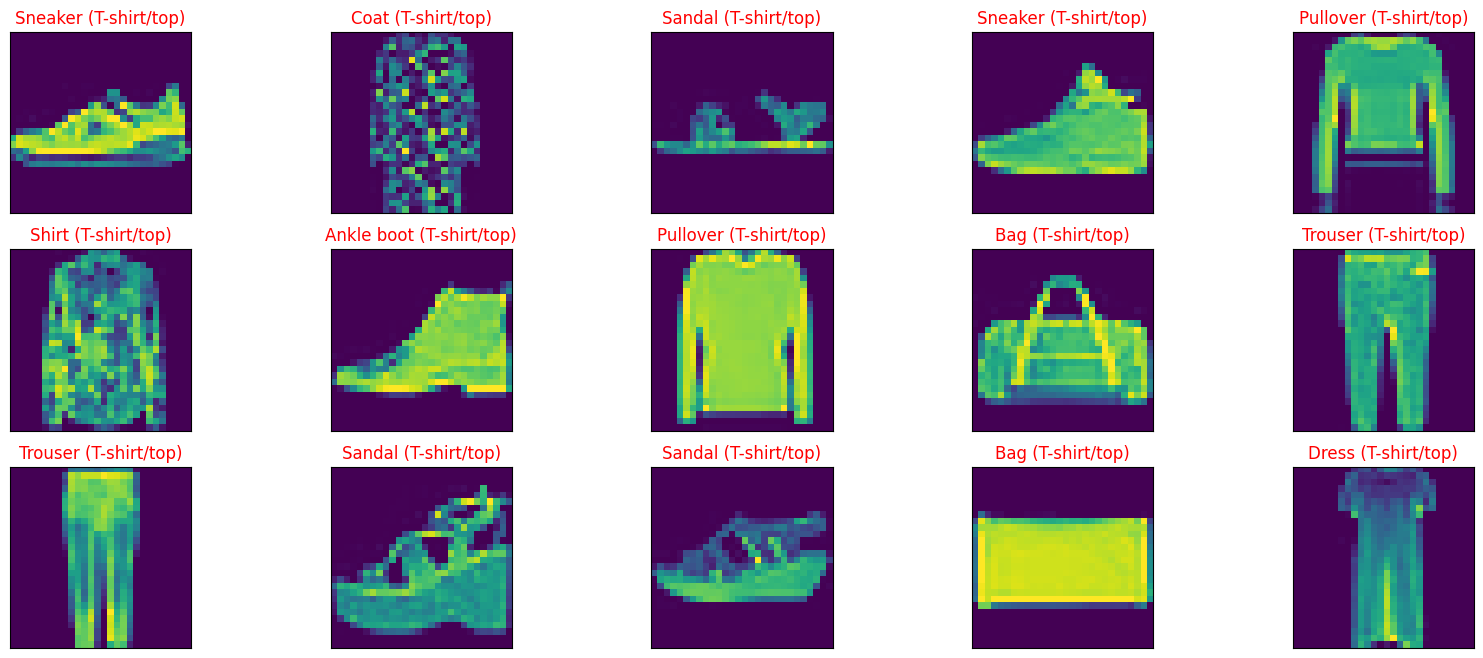

In [44]:
# y_hat = model.predict(test_images)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = np.argmax(predictions[index])
    true_index = np.argmax(test_labels[index])
    # true_index = index
    # Set the title for each image
    ax.set_title("{} ({})".format(fmnist_labels[predict_index], 
                                  fmnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))